In [1]:
from pathlib import Path
import sys
import os
import json

from pybloom import BloomFilter
import math, time
import pandas as pd
import regex as re
import pickle
from tensorflow.keras.models import save_model, load_model
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
# %pip install --upgrade tensorflow --user

In [2]:
dataQuery = pd.read_csv("queries.csv")
dataQuery['files'].value_counts()

LaptopPeriferals       2500
Laptop                 2500
Mobile                 2500
Refrigerator           2500
Tablet                 2500
TV                     2500
WashingMachine         2500
WearableSmartDevice    2500
CameraLens             2157
Name: files, dtype: int64

In [3]:
dataQuery['token_count'] = dataQuery['queries'].str.split().str.len()

In [4]:
dataQuery['token_count'].value_counts()


4     3966
2     3796
6     2775
8     2572
10    2222
5     2033
7     1989
9     1641
3      684
1      478
11       1
Name: token_count, dtype: int64

In [7]:
initial_data = []
path = sys.path[0] + '\\data'
json_files = [pos_json for pos_json in os.listdir(
        path) if pos_json.endswith('.json')]
for index, js in enumerate(json_files):
    with open(os.path.join(path, js)) as json_file:
        data = json.load(json_file)
        initial_data.append(data)

In [30]:
import random
tokens_length = [1,2,4,6,8,10]
queries = []
for length in tokens_length:
    temp = list(dataQuery[dataQuery['token_count'] == length]['queries'])
    random.shuffle(temp)
    queries.append(temp[:200])
    
print(len(queries))
print(len(queries[0]))
    

6
200


In [10]:
initial_method = []
for query in queries:
    total_sum = 0
    for target_query in query:
        sum = 0
        for epochs in range(5):
            keywords = target_query.split()

            itemSet = []

            items = []

            start = time.time()

            for i in range(len(initial_data)):
                data_filter = initial_data[i]
                for j in range(len(data_filter)):
                    count = 0
                    for k in range(len(keywords)):
                        keys = list(map(lambda x: x.lower(), data_filter[j].keys()))
                        values = list(map(lambda x: x.lower(), data_filter[j].values()))
                        if keywords[k] in keys or keywords[k] in values:
                            count = count + 1
                        else:
                            break
                    if count == len(keywords):
                        itemSet.append(j)
                if len(itemSet) != 0:
                    for item in range(len(itemSet)):
                        items.append(initial_data[i][itemSet[item]]) 
                    break
                itemSet = []
                
            end = time.time()
            
            sum += (end - start)
        total_sum += sum / 5
    total_sum = total_sum / 200
    initial_method.append(total_sum)        
                

In [90]:
target_query = 'black dayneo type wireless'

In [92]:
keywords = target_query.split()

itemSet = []

items = []

start = time.time()

for i in range(len(initial_data)):
    data_filter = initial_data[i]
    for j in range(len(data_filter)):
        count = 0
        for k in range(len(keywords)):
            keys = list(map(lambda x: x.lower(), data_filter[j].keys()))
            values = list(map(lambda x: x.lower(), data_filter[j].values()))
            if keywords[k] in keys or keywords[k] in values:
                count = count + 1
            else:
                break
        if count == len(keywords):
            itemSet.append(j)
    if len(itemSet) != 0:
        for item in range(len(itemSet)):
            items.append(initial_data[i][itemSet[item]]) 
        break
    itemSet = []
                
end = time.time()
print("{:5.6f} seconds to retreive the itemSet".format(end - start))       
                    
print(items)
# if len(itemSet) == 0:
#     print("No common items found in the itemSet")
# else:
#     print(itemSet)
        

0.355261 seconds to retreive the itemSet
[{'Battery-Chargeable': 'Yes', 'Battery-Included': 'Yes', 'Brand': 'DAYNEO', 'Brand-Color': 'Black', 'Charging-Method': 'cable', 'Charging-Time': '1-hr', 'Color': 'Black', 'Model-Number': 'T8-HD-Audio-Earbuds-With-Portable-Charging-Box', 'One-Touch-Button': 'Yes', 'Operating-System-Supported': 'Bluetooth', 'Other-Audio-Features': 'Pure-Bass-Performance', 'Sales-Package': '1-Set-Of-Earbuds', 'Standby-Time': '48-hr', 'Sweat-Proof': 'Yes', 'Touch-Control': 'Yes', 'Type': 'Wireless', 'Type-of-Tracking': 'Distance', 'Usage': 'Gaming-&-Entertainment', 'Water-Resistant': 'No', 'id': '14001'}, {'Battery-Chargeable': 'Yes', 'Battery-Included': 'Yes', 'Brand': 'DAYNEO', 'Brand-Color': 'Black', 'Charging-Method': 'cable', 'Charging-Time': '1-hr', 'Color': 'Black', 'Foot-Pods-Included': 'Yes', 'Function': 'Water-proof-Smart-fitness-Band-with-Bluetooth-or-Heart-Rate-sensor,Activity-Records,-Sleep-Monitor,-Calore-Burned,-Rejected-Calling,-Alarm,-Blood-Pressur

In [11]:
initial_method = [ '%.5f' % elem for elem in initial_method]
print(initial_method)

['0.02608', '0.03507', '0.06239', '0.05900', '0.06274', '0.05955']


In [15]:
library = {}
target_names = []

In [16]:
path = sys.path[0] + '\\data_with_ids'
json_files = [pos_json for pos_json in os.listdir(
        path) if pos_json.endswith('.json')]
for index, js in enumerate(json_files):
    with open(os.path.join(path, js)) as json_file:
        data = json.load(json_file)
        filename = Path(json_file.name)
        target_name = re.sub('.json','',filename.name)
        target_names.append(target_name)
        library[target_name] = {'data':{},'inverted_index_ds':{},'filter':{},'filter1':{}}
        library[target_name]['data'] = data
        

In [17]:
path = sys.path[0] + '\\inverted-index-ds'
json_files = [pos_json for pos_json in os.listdir(
        path) if pos_json.endswith('.json')]
for index, js in enumerate(json_files):
    with open(os.path.join(path, js)) as json_file:
        data = json.load(json_file)
        filename = Path(json_file.name)
        target_name = re.sub('_DS.json','',filename.name)
        library[target_name]['inverted-index-ds'] = data

In [18]:
flag = 0
path = sys.path[0] + '\\Bloom-Filters'
filter_files = [pos_json for pos_json in os.listdir(
        path)]
for index, js in enumerate(filter_files):
    with open(os.path.join(path, js),'rb') as filter_file:
        filename = Path(filter_file.name)
        target_name = re.sub('(_Filter)|1','',filename.name)
        if flag == 0:
            library[target_name]['filter'] = BloomFilter.fromfile(filter_file)
            flag = 1
        else:
            library[target_name]['filter1'] = BloomFilter.fromfile(filter_file)
            flag = 0

In [21]:
check = list(library['CameraLens']['filter'])
print(check)

TypeError: 'BloomFilter' object is not iterable

In [19]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #.+_-]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    text = re.sub('-',' ',text)
    return text

In [20]:
with open('results/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [21]:
# %pip install keras_preprocessing --user

In [22]:
saved_model = load_model(sys.path[0] + '\\results\\query_model.model',compile=True)

In [31]:
optimized_method = []
MAX_SEQUENCE_LENGTH = 32
for query in queries:
    total_sum = 0
    for target_query in query:
        sum = 0
        for epochs in range(5):            
            itemSet = []

            final_items = []

            index = 0
            
            queryCheck = clean_text(target_query)
            X_analyze = tokenizer.texts_to_sequences([queryCheck])
            X_analyze = pad_sequences(X_analyze, maxlen=MAX_SEQUENCE_LENGTH)
            predicted_files = saved_model.predict(X_analyze)
            filenames = [val for (_, val) in sorted(zip(predicted_files[0], library.keys()), key=lambda x: x[0],reverse = True)]

            keywords = target_query.split()

            target_file = ""

            start = time.time()
            
            for filename in filenames:
                count = 0
                while count < len(keywords):
                    if keywords[count] in library[filename]['filter']:
                        if(type(library[filename]['inverted-index-ds'][keywords[count]]) is dict):
                            if((len(keywords) > 1) and ((count+1) != len(keywords))):
                                key_level0 = keywords[count]
                                count = count + 1
                                key_filter = key_level0 + ' ' + keywords[count]
                                if key_filter in library[filename]['filter1']:
                                    itemSet.append(library[filename]['inverted-index-ds'][key_level0][keywords[count]])
                                else:
                                    count = count - 1
                                    keys = library[filename]['inverted-index-ds'][keywords[count]].keys()
                                    for key in keys:
                                        itemSet.append(library[filename]['inverted-index-ds'][keywords[count]][key])
                            else:
                                keys = library[filename]['inverted-index-ds'][keywords[count]].keys()
                                for key in keys:
                                    itemSet.append(library[filename]['inverted-index-ds'][keywords[count]][key])
                        else:
                            itemSet.append(library[filename]['inverted-index-ds'][keywords[count]])
                        count = count + 1
                    else: 
                        break
                    
                if count == len(keywords):
                    items = list(set.intersection(*map(set,itemSet)))
                    target_file = filename
                    break
            
                itemSet = []
                
            if len(itemSet) == 0:
                continue   
            else:
                for item_id in items:
                    final_items.append(library[filename]['data'][item_id])
                    
            end = time.time()
            sum += (end - start)
        total_sum += sum / 5
    total_sum = total_sum / 200
    optimized_method.append(total_sum)  

1/1 [==============================] - 0s 33ms/step


In [94]:
MAX_SEQUENCE_LENGTH = 32      
itemSet = []

final_items = []

index = 0

queryCheck = clean_text(target_query)
X_analyze = tokenizer.texts_to_sequences([queryCheck])
X_analyze = pad_sequences(X_analyze, maxlen=MAX_SEQUENCE_LENGTH)
predicted_files = saved_model.predict(X_analyze)
filenames = [val for (_, val) in sorted(zip(predicted_files[0], library.keys()), key=lambda x: x[0],reverse = True)]

keywords = target_query.split()

target_file = ""

start = time.time()

for filename in filenames:
    count = 0
    while count < len(keywords):
        if keywords[count] in library[filename]['filter']:
            if(type(library[filename]['inverted-index-ds'][keywords[count]]) is dict):
                if((len(keywords) > 1) and ((count+1) != len(keywords))):
                    key_level0 = keywords[count]
                    count = count + 1
                    key_filter = key_level0 + ' ' + keywords[count]
                    if key_filter in library[filename]['filter1']:
                        itemSet.append(library[filename]['inverted-index-ds'][key_level0][keywords[count]])
                    else:
                        count = count - 1
                        keys = library[filename]['inverted-index-ds'][keywords[count]].keys()
                        for key in keys:
                            itemSet.append(library[filename]['inverted-index-ds'][keywords[count]][key])
                else:
                    keys = library[filename]['inverted-index-ds'][keywords[count]].keys()
                    for key in keys:
                        itemSet.append(library[filename]['inverted-index-ds'][keywords[count]][key])
            else:
                itemSet.append(library[filename]['inverted-index-ds'][keywords[count]])
            count = count + 1
        else: 
            break
        
    if count == len(keywords):
        items = list(set.intersection(*map(set,itemSet)))
        target_file = filename
        break

    itemSet = []
    
if len(itemSet) == 0:
    print("No items found")
else:
    for item_id in items:
        final_items.append(library[filename]['data'][item_id])
    
end = time.time()

print("{:5.6f} seconds to retreive the itemSet".format(end - start))

print(final_items)
# print(items)

1/1 [==============================] - 1s 520ms/step
0.001001 seconds to retreive the itemSet
[{'Battery-Chargeable': 'Yes', 'Battery-Included': 'Yes', 'Brand': 'DAYNEO', 'Brand-Color': 'Black', 'Charging-Method': 'cable', 'Charging-Time': '1-hr', 'Color': 'Black', 'Model-Number': 'T8-HD-Audio-Earbuds-With-Portable-Charging-Box', 'One-Touch-Button': 'Yes', 'Operating-System-Supported': 'Bluetooth', 'Other-Audio-Features': 'Pure-Bass-Performance', 'Sales-Package': '1-Set-Of-Earbuds', 'Standby-Time': '48-hr', 'Sweat-Proof': 'Yes', 'Touch-Control': 'Yes', 'Type': 'Wireless', 'Type-of-Tracking': 'Distance', 'Usage': 'Gaming-&-Entertainment', 'Water-Resistant': 'No'}, {'Battery-Chargeable': 'Yes', 'Battery-Included': 'Yes', 'Brand': 'DAYNEO', 'Brand-Color': 'Black', 'Charging-Method': 'cable', 'Charging-Time': '1-hr', 'Color': 'Black', 'Compatible-Devices': 'IPHONE,-APPLE,-HTC,-MI,-SONY,-MICROMAX,-HP,-SAMSUNG,HONOR,-LYF,-PANASONIC,-NOKIA,-GIONEE,-ONEPLUS,-MOTO,-MOTOROLA,-VIVO,-OPPO,-LENOVO'

In [32]:
optimized_method = [ '%.5f' % elem for elem in optimized_method]
print(optimized_method)

['0.00005', '0.00010', '0.00010', '0.00008', '0.00010', '0.00010']


Text(0, 0.5, 'Time Consumed (in seconds')

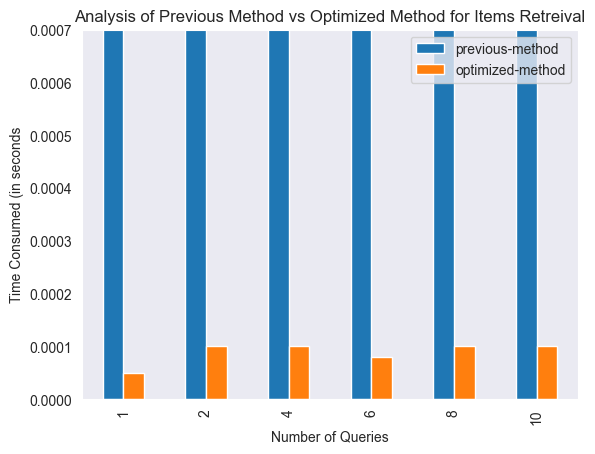

In [51]:
initial_method = [float(x) for x in initial_method]
optimized_method = [float(x) for x in optimized_method]
import matplotlib.pyplot as plt
import seaborn as sns

plotdata = pd.DataFrame({
    "previous-method":initial_method,
    "optimized-method":optimized_method,
    }, 
    index=["1", "2", "4", "6", "8", "10"]
)

sns.set_style("dark")
plotdata.plot(kind="bar")
plt.ylim(0, 0.0007)
plt.title("Analysis of Previous Method vs Optimized Method for Items Retreival")
plt.xlabel("Number of Queries")
plt.ylabel("Time Consumed (in seconds")


In [44]:
optimized_method

[5e-05, 0.0001, 0.0001, 8e-05, 0.0001, 0.0001]

In [82]:
# %pip install seaborn --user

In [119]:
saved_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 32, 100)           5000000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 32, 100)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 9)                 909       
                                                                 
Total params: 5,081,309
Trainable params: 5,081,309
Non-trainable params: 0
_________________________________________________________________
